# Data gathering

## Imports

In [1]:
#%matplotlib inline
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pl
from matplotlib.ticker import FormatStrFormatter

params = {'axes.labelsize': 'large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
pl.rcParams.update(params)

unfiltered_data = pd.read_table('final_data_updated.csv', delimiter=',')

## Remove corrupted or invalid data

In [2]:
invalid_value_mask = np.equal(unfiltered_data, -1)
invalid_rows_mask = np.any(invalid_value_mask, axis=1)
data = unfiltered_data[~invalid_rows_mask]

## Specific projects

In [3]:
data = data.loc[data['Project'].isin(['Math', 'Time', 'Lang', 'Closure', 'Chart'])]
print(data['Project'].unique())

['Chart' 'Closure' 'Lang' 'Math' 'Time']


## Label

In [4]:
label = 'L-10'
y = data[label]

## Dataset split method

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

def createTestSet(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler = MinMaxScaler()
    X_train = getScaledDataset(X_train)
    X_test = getScaledDataset(X_test)
    return (X_train, X_test, y_train, y_test)

def getScaledDataset(X):
    scaler = MinMaxScaler()
    return scaler.fit_transform(X)

# GridSearch

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

#X = data.filter(regex="(S|D|T|B)-.*")
X = data[['S-WordCount', 'T-AvgVEFT', 'T-%VEP^FT', 'B-SizeInLines']]

X_train, X_test, y_train, y_test = createTestSet(X,y)

parameters = {'C':np.arange(0.1,10,0.1)}
clf = GridSearchCV(LogisticRegression(), parameters, n_jobs=-1, cv=5)
clf.fit(X=X_train, y=y_train)

parameter = clf.best_params_
model = clf.best_estimator_

print("GridSearch training set results:")
print(clf.best_score_, parameter)
print("Score on test set:")
print(model.score(X_test, y_test))
print("Score on whole dataset:")
print(model.score(getScaledDataset(X), y))

GridSearch training set results:
0.8834586466165414 {'C': 6.4}
Score on test set:
0.8208955223880597
Score on whole dataset:
0.8588588588588588


# Visualization

<IPython.core.display.Javascript object>


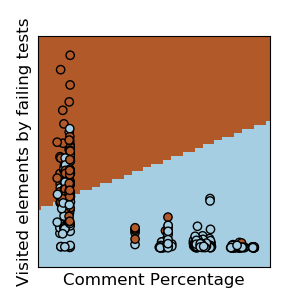

In [12]:
h = .02
border = 0.1
X = getScaledDataset(data[['S-ComPer', 'T-AvgVEFT']])
linreg = LogisticRegression(**parameter)
linreg.fit(X,y)


x_min, x_max = X[:, 0].min() - border, X[:, 0].max() + border
y_min, y_max = X[:, 1].min() - border, X[:, 1].max() + border
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = linreg.predict(np.c_[xx.ravel(), yy.ravel()])

# color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(3, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# training points
plt.xlabel('Comment Percentage')
plt.ylabel('Visited elements by failing tests')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap=plt.cm.Paired);